# Example: Mixed-Element Mesh for Delineated Watershed

This workflow provides a part of worlflow to develop an streamaligned mixed-element mesh for Taylorupstream watershed. Long quad elements with pentagons at junctions are placed along NHDPlus flowlines to represent rivers/streams. Rest of the domain is meshed with standard TIN. This example has internal huc boundaries that are modified to accomodate river corridor. This workflow only shows steps to get a terrain following 2D surface mesh. Rest of the steps are same as other examples

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation

In [1]:
## Importing all the package needed to run teh watershed workflow
# conda package imports
import os,sys
import numpy as np
import pandas
from matplotlib import pyplot as plt
import logging
import pandas as pd
import seaborn as sns
import copy
import scipy

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.condition
import watershed_workflow.densify_rivers_hucs
import watershed_workflow.create_river_mesh
watershed_workflow.ui.setup_logging(1,None)

In [2]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'Taylor_Upstream' # name the domain, used in filenames, etc
hucs = ['140200010101','140200010102','140200010103'] # a list of HUCs to run
huc_level = 12 # if provided, an int setting the level at which to include HUC boundaries
modis_name = None

# geometric parameters
simplify = 100 # length scale to target average edge
simplify_rivers = 100
stream_outlet_width = 500 # half-width to track a labeled set on which to get discharge
ignore_small_rivers = 2 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.02 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
prune_by_area_fraction_waterbodies = None
num_smoothing_sweeps = 5 # number of times to smooth the DEM prior to elevating

# simulation control
start_year = 1980  # year to start and end simulation simulation -- note these start and end Oct 1 of the year
end_year = 2020
min_porosity = 0.05 # minimum porosity considered too small
max_permeability = 1.e-10 # max value allowed for permeability
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils

# triangle refinement control
include_rivers = True
refine_d0 = 100
refine_d1 = 500
refine_A0 = 8000
refine_A1 = 50000

# soil structure
use_geologic_layer = True

# logistics
generate_plots = True # plots take time to make and aren't always needed
generate_daymet = True # potentially don't do Met data forcing
generate_modis = True

include_heterogeneous = True
include_homogeneous = False # if true, also write files for homogeneous runs
include_homogeneous_wrm = False # if true, also write files for homogeneous WRMs
include_homogeneous_wrm_porosity = False # if true, also write files for homogeneous porosity and WRMs
include_homogeneous_wrm_permeability = False # if true, also write files for homogeneous perm and WRMs

log_to_file = False  # if true, write to file instead of in the notebook output
figsize = (6,6)
figsize_3d = (8,6)

In [3]:
# parameter checking
assert(simplify > 0 and simplify < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))
assert(start_year >= 1980 and start_year < 2020)

if type(hucs) is str:
    assert(hucs[0] == '[')
    assert(hucs[-1] == ']')
    hucs = hucs[1:-1]
    hucs = hucs.split(',')
    hucs = [h.strip() for h in hucs]
    if hucs[-1] == '':
        hucs = hucs[:-1]

if huc_level is None:
    huc_level = len(hucs[0])
else:
    assert(huc_level >= len(hucs[0]))
huc_key = f'HUC{huc_level}'

if prune_by_area_fraction_waterbodies is None:
    prune_by_area_fraction_waterbodies = prune_by_area_fraction * 0.1


In [4]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [5]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [6]:
logging.info("")
logging.info(f"Meshing shape: {hucs}")
logging.info("="*30)


2023-02-12 14:41:35,006 - root - INFO: 
2023-02-12 14:41:35,007 - root - INFO: Meshing shape: ['140200010101', '140200010102', '140200010103']
2023-02-12 14:41:35,007 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [7]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = watershed_workflow.source_list.dem_sources['NED 1/3 arc-second']
watershed_workflow.source_list.log_sources(sources)

2023-02-12 14:41:35,721 - root - INFO: Using sources:
2023-02-12 14:41:35,721 - root - INFO: --------------
2023-02-12 14:41:35,722 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-02-12 14:41:35,722 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-02-12 14:41:35,722 - root - INFO: DEM: National Elevation Dataset (NED)
2023-02-12 14:41:35,722 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2023-02-12 14:41:35,723 - root - INFO: geologic structure: GLHYMPS version 2.0
2023-02-12 14:41:35,723 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2023-02-12 14:41:35,723 - root - INFO: lai: MODIS
2023-02-12 14:41:35,723 - root - INFO: soil thickness: None
2023-02-12 14:41:35,724 - root - INFO: meteorology: DayMet 1km


In [8]:
# load the huc
my_hucs = []
for huc in hucs:
    _, ws = watershed_workflow.get_hucs(sources['HUC'], huc, huc_level, crs)
    my_hucs.extend(ws)

watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)

2023-02-12 14:41:36,059 - root - INFO: 
2023-02-12 14:41:36,059 - root - INFO: Loading level 12 HUCs in 140200010101
2023-02-12 14:41:36,059 - root - INFO: ------------------------------
/Users/7s2/opt/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tnmaccess.nationalmap.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2023-02-12 14:41:38,940 - root - INFO:   REST URL: https://tnmaccess.nationalmap.gov/api/v1/products?datasets=National+Hydrography+Dataset+Plus+High+Resolution+%28NHDPlus+HR%29&polyType=huc4&polyCode=1402
2023-02-12 14:41:38,941 - root - INFO: Checking match for 1402? https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHDPlusHR/Beta/GDB/NHDPLUS_H_1102_HU4_GDB.zip
2023-02-12 14:41:38,942 - root - INFO: format in match? True
2023-02

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

### Get river network

This will download the river network from the NHD Plus database, and simplify the network, constructing a tree-like data structure.

In [9]:
# what about the reservoir!
_, waterbodies = watershed_workflow.get_waterbodies(sources['hydrography'], huc, my_hucs[0], crs, crs, 
                                                    prune_by_area=prune_by_area_fraction_waterbodies*my_hucs[0].area)

2023-02-12 14:42:04,872 - root - INFO: 
2023-02-12 14:42:04,873 - root - INFO: Loading Water Bodies
2023-02-12 14:42:04,873 - root - INFO: ------------------------------
2023-02-12 14:42:04,873 - root - INFO: Loading waterbodies in HUC 140200010103
2023-02-12 14:42:04,873 - root - INFO:          and/or bounds (-562803.8965103577, -359871.01201552415, -545801.220296083, -342804.74996838445)
2023-02-12 14:42:04,874 - root - INFO:   Using Hydrography file "/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2023-02-12 14:42:04,874 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb' layer 'NHDWaterbody' for streams in '(-562803.8965103577, -359871.01201552415, -545801.220296083, -342804.74996838445)'
2023-02-12 14:42:04,903 - root - INFO:   Found total of 368 in bounds.
2023-02-12 14:42:04,903 - root - INFO: ... foun

In [11]:
include_rivers=True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], "1402", 
                                                watershed.exterior(), crs, crs,
                                                in_network=True, properties=True)
    
    rivers = watershed_workflow.construct_rivers(watershed, reaches, method='hydroseq',
                                                 ignore_small_rivers=ignore_small_rivers,
                                                 prune_by_area_fraction=prune_by_area_fraction,
                                                 remove_diversions=True,
                                                 remove_braided_divergences=True)

2023-02-12 14:42:20,987 - root - INFO: 
2023-02-12 14:42:20,987 - root - INFO: Loading Hydrography
2023-02-12 14:42:20,987 - root - INFO: ------------------------------
2023-02-12 14:42:20,987 - root - INFO: Loading streams in HUC 1402
2023-02-12 14:42:20,988 - root - INFO:          and/or bounds (-562803.8965103577, -365142.00558721035, -534357.7588395509, -342804.74996838445)
2023-02-12 14:42:20,989 - root - INFO:   Using Hydrography file "/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2023-02-12 14:42:20,989 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb' layer 'NHDFlowline' for streams in '(-562803.8965103577, -365142.00558721035, -534357.7588395509, -342804.74996838445)'
2023-02-12 14:42:21,214 - root - INFO:   Found total of 2479 in bounds.
2023-02-12 14:42:21,214 - root - INFO:   Filtering reaches

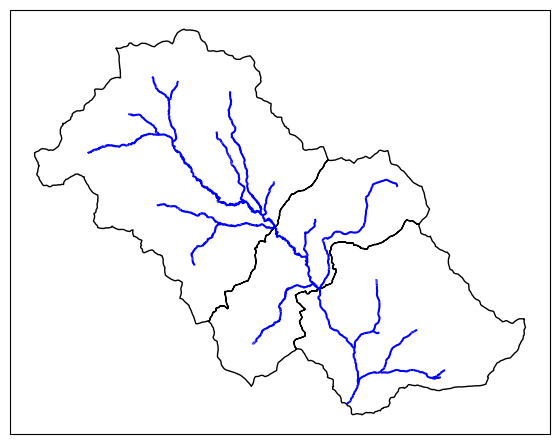

In [12]:
if generate_plots:
    fig = plt.figure(figsize=figsize)
    ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])    
    
    watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
    watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
    watershed_workflow.plot.shplys(waterbodies, crs, 'g', ax, facecolor='c')
    plt.show()

In [13]:
# keeping the originals
rivers_orig=[river.deep_copy() for river in rivers]
watershed_orig=copy.deepcopy(watershed) 

# simplifying 
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=150, simplify_rivers=80, merge_tol=50,
                           snap=True, cut_intersections=True)

# for plotting purpose only
rivers_simplified=[river.deep_copy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

print('number of reaches in original', len(rivers_orig[0]), 'number of reaches in simplified', len(rivers[0]))

2023-02-12 14:44:03,200 - root - INFO: 
2023-02-12 14:44:03,200 - root - INFO: Simplifying
2023-02-12 14:44:03,201 - root - INFO: ------------------------------
2023-02-12 14:44:03,201 - root - INFO: Simplifying rivers
2023-02-12 14:44:03,218 - root - INFO:   ...cleaned inner segment of length 9.29357 at centroid (-544055.1068340249, -363377.48627413163)
2023-02-12 14:44:03,221 - root - INFO:   ...cleaned inner segment of length 20.5515 at centroid (-542663.4698560818, -362723.0546266398)
2023-02-12 14:44:03,222 - root - INFO:   ...cleaned inner segment of length 11.6351 at centroid (-542429.5430728602, -362698.18188702635)
2023-02-12 14:44:03,224 - root - INFO:   ...cleaned inner segment of length 10.4796 at centroid (-540965.1406121335, -360414.0907295551)
2023-02-12 14:44:03,224 - root - INFO:   ...cleaned inner segment of length 15.3334 at centroid (-540960.9389859297, -360408.11970226484)
2023-02-12 14:44:03,226 - root - INFO:   ...cleaned inner segment of length 28.6872 at centro

number of reaches in original 274 number of reaches in simplified 167


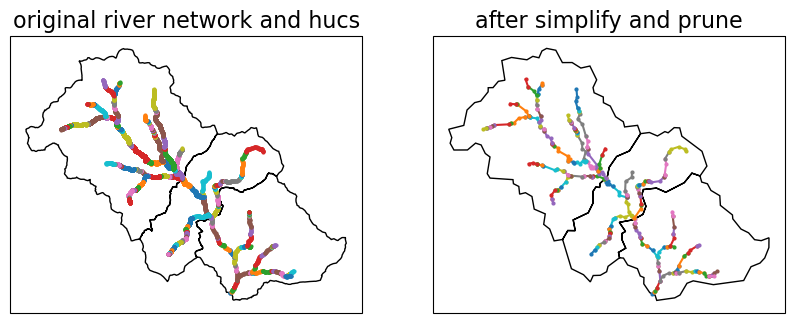

In [16]:
plt.rcParams['figure.figsize'] = [10, 10]
watershed_workflow.ui.setup_logging(1,None)

fig, axs = plt.subplots(1,2,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)})
watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs[0])
axs[0].set_title('original river network and hucs',fontsize=16)
watershed_workflow.plot.hucs(watershed, crs, 'k', axs[1])
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_orig:

    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=2)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=2)
plt.show()

In [17]:
d0 = 20; d1 = 100
L0 = 100; L1 = 250

# densify_watershed
watershed = watershed_workflow.densify_rivers_hucs.densify_hucs(watershed, watershed_orig, rivers, use_original=True, limit_scales=[d0,L0,d1,L1]) 

#densify_river
rivers=watershed_workflow.densify_rivers_hucs.densify_rivers(rivers, rivers_orig, limit=120, use_original=True, treat_collinearity=True)

2023-02-12 14:45:21,506 - root - INFO:   river min seg length: 51.644597373587295
2023-02-12 14:45:21,507 - root - INFO:   river median seg length: 91.73076860751857


<module 'matplotlib.pyplot' from '/Users/7s2/opt/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/matplotlib/pyplot.py'>

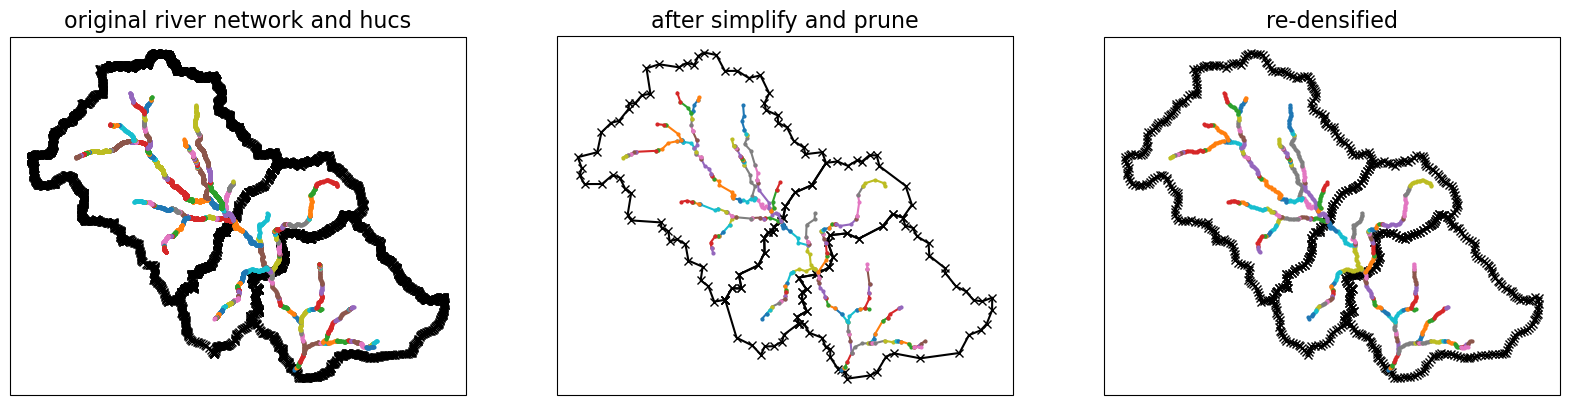

In [19]:
# plotting results
plt.rcParams['figure.figsize'] = [20, 12]

fig, axs = plt.subplots(1,3,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)})

for huc in list(watershed_orig.polygons()):
    axs[0].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
for huc in list(watershed_simplified.polygons()):
    axs[1].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)
for huc in list(watershed.polygons()):
    axs[2].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x')
axs[2].set_title('re-densified',fontsize=16)
axs[2].plot()

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=2)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=2)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[2].plot(x,y,'-o',markersize=2)
plt

In [21]:
# hpow many types of Stream Orders are there
set([r.properties["StreamOrder"] for r in rivers[0].preOrder()])

{2, 3, 4, 5}

In [25]:
## create river corridor polygon and river topology
widths = dict({2:10,3:20,4:30,5:30}) 
quads, corrs = watershed_workflow.create_river_mesh.create_rivers_meshes(rivers=rivers, widths=widths, enforce_convexity=True)

# want to get modified huc integrated with RC?
watershed_modified = watershed_workflow.create_river_mesh.adjust_hucs_for_river_corridor(copy.deepcopy(watershed), rivers[0], corrs[0], integrate_rc = True)

2023-02-12 14:51:29,005 - root - INFO: creating river corridor polygon
2023-02-12 14:51:29,005 - root - INFO: river min seg length: 51.644597373587295
2023-02-12 14:51:29,006 - root - INFO: merging points closer than this distance along the river corridor: 43.644597373587295
2023-02-12 14:51:29,018 - root - INFO: defining river-mesh topology (quad elements)
2023-02-12 14:51:29,080 - root - INFO: setting width of quad elements based on StreamOrder
2023-02-12 14:51:29,098 - root - INFO: found outlet junction
2023-02-12 14:51:29,099 - root - INFO: Modifying HUC Segment 6
2023-02-12 14:51:29,100 - root - INFO: Modifying HUC Segment 3
2023-02-12 14:51:29,103 - root - INFO: Modifying HUC Segment 4
2023-02-12 14:51:29,104 - root - INFO: Modifying HUC Segment 7
2023-02-12 14:51:29,106 - root - INFO: Modifying HUC Segment 5
2023-02-12 14:51:29,107 - root - INFO: Modifying HUC Segment 8


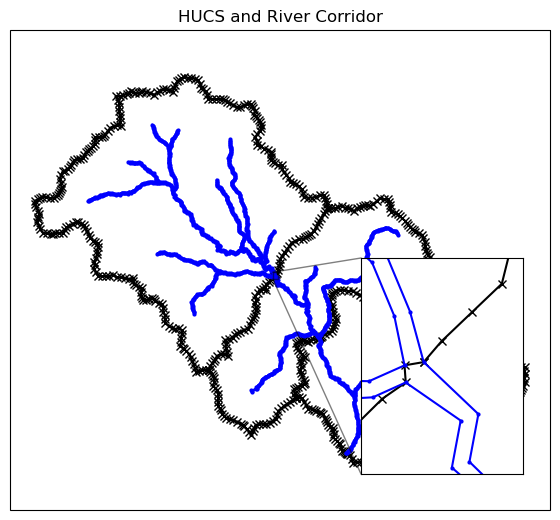

In [140]:
## plotting river corridor and huc
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])

for segment in watershed_modified.segments:
    x, y = segment.xy
    ax.plot(x, y, 'k-x')
for corr in corrs:   
    ax.plot(corr.exterior.xy[0], corr.exterior.xy[1], 'b-o', markersize=2)
ax.set_title('HUCS and River Corridor')
ax.set_aspect('equal', 'datalim')


for segment in watershed_modified.segments:
    x, y = segment.xy
    ax2.plot(x, y, 'k-x')
for corr in corrs:   
    ax2.plot(corr.exterior.xy[0], corr.exterior.xy[1], 'b-o', markersize=2)
ax2.set_aspect('equal')

xlim = (-549000, -548700)
ylim = (-354500, -354100)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')
plt.show()

In [138]:
(-549000 +dx, -548700+dx)

(-544850, -544550)

In [76]:
## Triangulation

refine_d0 = 150 ##150
refine_d1 = 400
refine_A0 = 10000
refine_A1 = 50000

d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 # [100, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

points, elems= watershed_workflow.triangulate(watershed,rivers ,corrs, mesh_rivers=True,
                                              refine_min_angle=32,refine_distance=[d0,A0,d1,A1],
                                              diagnostics=False)

2023-02-12 15:03:45,526 - root - INFO: 
2023-02-12 15:03:45,527 - root - INFO: Meshing
2023-02-12 15:03:45,527 - root - INFO: ------------------------------
2023-02-12 15:03:45,534 - root - INFO: Triangulating...
2023-02-12 15:03:45,534 - root - INFO: Adjusting hucs to accomodate river corridor
2023-02-12 15:03:45,541 - root - INFO: found outlet junction
2023-02-12 15:03:45,542 - root - INFO: Modifying HUC Segment 6
2023-02-12 15:03:45,543 - root - INFO: Modifying HUC Segment 3
2023-02-12 15:03:45,548 - root - INFO: Modifying HUC Segment 4
2023-02-12 15:03:45,549 - root - INFO: Modifying HUC Segment 7
2023-02-12 15:03:45,553 - root - INFO: Modifying HUC Segment 5
2023-02-12 15:03:45,554 - root - INFO: Modifying HUC Segment 8
2023-02-12 15:03:45,560 - root - INFO:    2425 points and 2430 facets
2023-02-12 15:03:45,560 - root - INFO:  checking graph consistency
2023-02-12 15:03:45,561 - root - INFO:  tolerance is set to 1
2023-02-12 15:03:45,568 - root - INFO:  building graph data struct

maximum area of the triangle 49946.347946 , minimum area of the triangle 75.61142 , number of triangles 16385


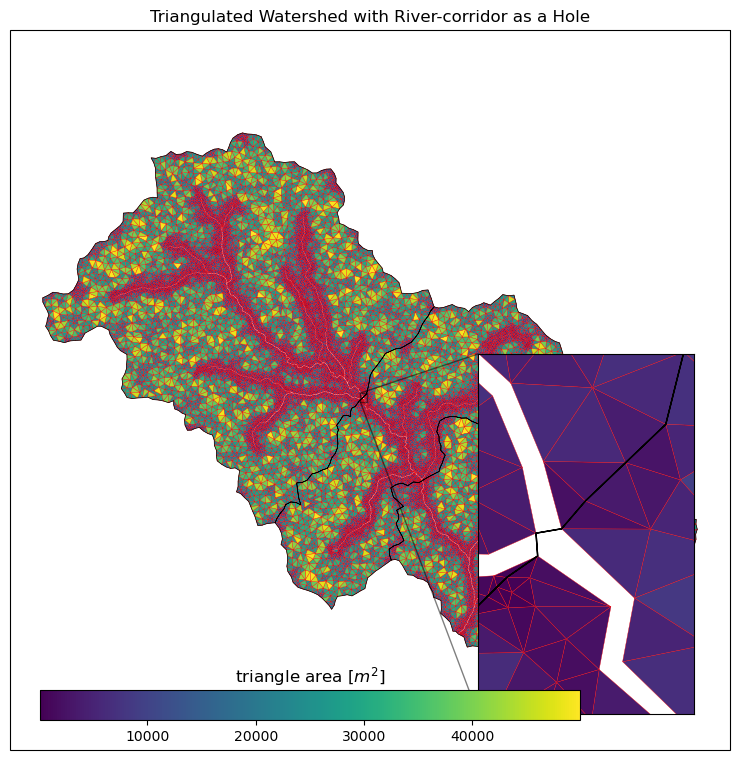

In [85]:
areas = np.array([watershed_workflow.utils.triangle_area(points[e]) for e in elems])
print('maximum area of the triangle', round(max(areas),6) ,', minimum area of the triangle', round(min(areas),6), ', number of triangles', len(areas))

# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0,0,1.2,1.2])
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp =ax.tripcolor(points[:,0], points[:,1], elems, areas, edgecolor='r')
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('Triangulated Watershed with River-corridor as a Hole')
watershed_workflow.plot.hucs(watershed_modified, crs, ax=ax, color='k', linewidth=0.5)
ax.set_aspect('equal', 'datalim')

mp2 =ax2.tripcolor(points[:,0], points[:,1], elems, areas, edgecolor='r')
watershed_workflow.plot.hucs(watershed_modified, crs, ax=ax2, color='k', linewidth=1)
ax2.set_aspect('equal', 'datalim')

xlim = (-549000, -548700)
ylim = (-354500, -354100)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('triangle area [$m^2$]')

plt.show()


In [88]:
# merging the list of river elenents with the triangulated mesh
elems_list=[elem.tolist() for elem in list(elems)]
for elem in quads:
    elems_list.append(elem)

In [89]:
# download the needed rasters
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2023-02-12 15:10:03,082 - root - INFO: 
2023-02-12 15:10:03,083 - root - INFO: Loading Raster
2023-02-12 15:10:03,084 - root - INFO: ------------------------------
2023-02-12 15:10:03,085 - root - INFO: Collecting raster
2023-02-12 15:10:03,091 - root - INFO: Collecting DEMs to tile bounds: [-106.81032954674818, 38.84352861677489, -106.43888797230935, 39.06593763312742]
2023-02-12 15:10:03,092 - root - INFO:   Need:
2023-02-12 15:10:03,093 - root - INFO:     /Users/7s2/Research/watershed_workflow_data/dem/USGS_NED_13as_n39_w107.tif
2023-02-12 15:10:03,093 - root - INFO:     /Users/7s2/Research/watershed_workflow_data/dem/USGS_NED_13as_n40_w107.tif
/Users/7s2/opt/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tnmaccess.nationalmap.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-

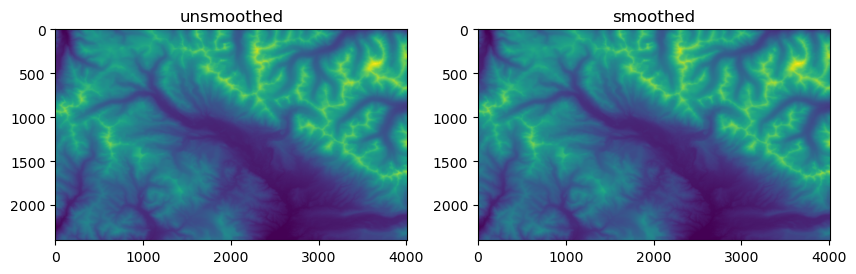

In [90]:
# noting that the DEM is a 30m raster, and we want to run at a coarser resolution of ~100-300m, 
# the DEM will look quite rough.  Smooth a small amount.  Note better algorithms could be used 
# here, but for now we just use Gaussian smoothing.
dem_sm = scipy.ndimage.gaussian_filter(dem, 1, mode='nearest')
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(dem)
axs[0].set_title('unsmoothed')
axs[1].imshow(dem_sm)
txt = axs[1].set_title('smoothed')

In [93]:
crs = watershed_workflow.crs.daymet_crs()
mesh_points3 = watershed_workflow.elevate(points, crs, dem, dem_profile)

In [94]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), elems_list)

In [95]:
# adding elevations to the river tree for stream bed conditioning
for river in rivers:
    for i, node in enumerate(river.preOrder()):

            node_points=(np.array(node.segment.xy).T)
            node_elevs = watershed_workflow.elevate(node_points, crs, dem, dem_profile)[:,2] 
            assert(len(node_elevs)==len(node.segment.coords))
            node.properties['elev_profile']=node_elevs

In [96]:
quad_ids=np.zeros((len(m2.conn)))

for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        quad_ids[i]=1
        

In [97]:
# # conditioning the river mesh using NHD elevations
watershed_workflow.condition.condition_river_mesh(m2, river)

In [99]:
watershed_workflow.split_hucs.find_outlets_by_hydroseq(watershed, rivers[0])

1


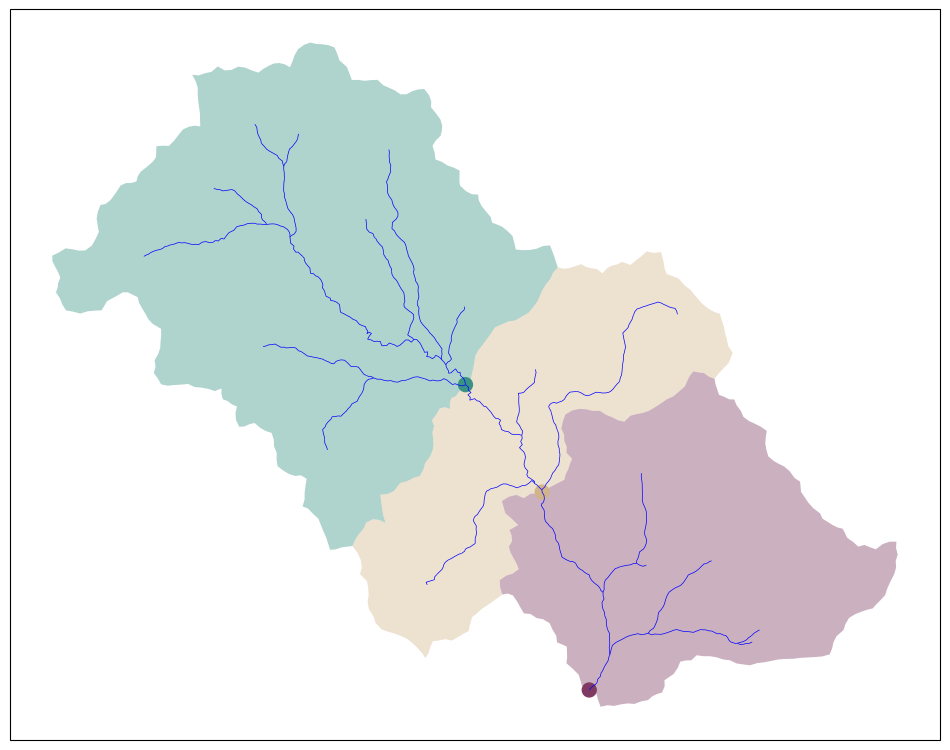

In [100]:
print(len(rivers))
rivers = sorted(rivers, key=len)
watershed_workflow.split_hucs.find_outlets_by_hydroseq(watershed, rivers[-1])

if generate_plots:
    fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(12,10))
    colors = watershed_workflow.colors.enumerated_colors(len(watershed), palette=4)
    watershed_workflow.plot.hucs(watershed, crs, ax=ax, color=colors, linewidth=1, facecolor='color', alpha=0.4)
    watershed_workflow.plot.rivers(rivers, crs, ax=ax, colors='b', linewidth=0.5)

kwargs =  {'linewidth': 0.1, 'cmap': <matplotlib.colors.ListedColormap object at 0x15063fa30>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x169894d30>, 'edgecolor': 'w', 'linestyle': '-'}
setting face color =  [2891.16622095 3626.51067163 3471.84910743 ... 2977.29552727 2980.86625463
 2984.04363978]
kwargs =  {'linewidth': 0.25, 'cmap': <matplotlib.colors.ListedColormap object at 0x15063fa30>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x169894d30>, 'edgecolor': 'w', 'linestyle': '-'}
setting face color =  [2891.16622095 3626.51067163 3471.84910743 ... 2977.29552727 2980.86625463
 2984.04363978]


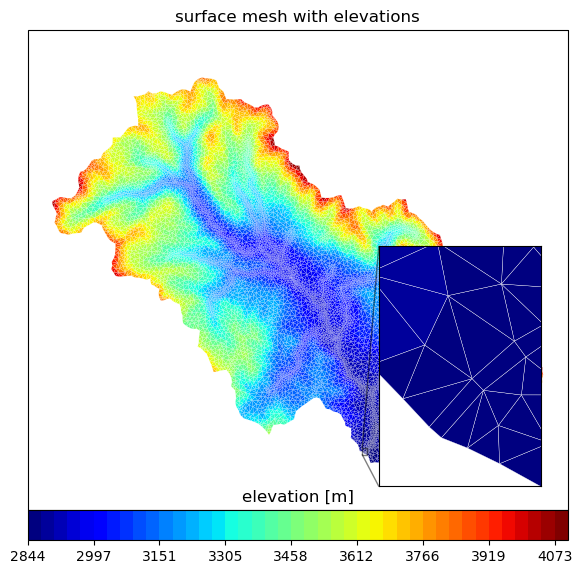

In [145]:
# plotting surface mesh with elevations
start=min(m2.centroids[:,2])
step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
stop=max(m2.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')


fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=0.1 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='w', facecolor='color')
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = watershed_workflow.plot.mesh(m2, crs, ax=ax2, 
                        linewidth=0.25 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='w', facecolor='color')
ax2.set_aspect('equal', 'datalim')

xlim =(-544850, -544550)
ylim = (-364650, -364250)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()


In [104]:
# add labeled sets for subcatchments and outlets
watershed_workflow.mesh.add_watershed_regions_and_outlets(m2, watershed, stream_outlet_width, 
                                                          labels=[p.properties[huc_key] for p in watershed.polygons()])

# add river corridor as region
watershed_workflow.mesh.add_river_corridor_regions(m2, corrs)


In [105]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

10000 : CELL : "140200010101"
10001 : CELL : "140200010101 surface"
10002 : CELL : "140200010102"
10003 : CELL : "140200010102 surface"
10004 : CELL : "140200010103"
10005 : CELL : "140200010103 surface"
10006 : FACE : "140200010101 boundary"
10007 : FACE : "140200010101 outlet"
10008 : FACE : "140200010102 boundary"
10009 : FACE : "140200010102 outlet"
10010 : FACE : "140200010103 boundary"
10011 : FACE : "140200010103 outlet"
10012 : FACE : "surface domain outlet"
10013 : CELL : "140200010101"
10014 : CELL : "140200010101 surface"
10015 : CELL : "140200010102"
10016 : CELL : "140200010102 surface"
10017 : CELL : "140200010103"
10018 : CELL : "140200010103 surface"
10019 : FACE : "140200010101 boundary"
10020 : FACE : "140200010101 outlet"
10021 : FACE : "140200010102 boundary"
10022 : FACE : "140200010102 outlet"
10023 : FACE : "140200010103 boundary"
10024 : FACE : "140200010103 outlet"
10025 : FACE : "surface domain outlet"
10026 : CELL : "river_corridor 0 surface"
